## CORACLE Set-up and Evaluation

In [1]:
### Data Processing

## Ignore warnings
import warnings
warnings.filterwarnings("ignore")
# Helper imports
import numpy as np
import pandas as pd
import os
import sys

from functools import reduce
import matplotlib.pyplot as plt

%matplotlib inline

# --- Setup Project Paths (This part remains the same) ---
current_working_dir = os.getcwd()
print(f"Current Working Directory: {current_working_dir}")
project_root = os.path.dirname(current_working_dir)
modules_path = os.path.join(project_root, 'Modules')
if modules_path not in sys.path:
    sys.path.append(modules_path)
    print(f"Added to sys.path for custom modules: {modules_path}")

####################################################################
#### Load Pre-Pivoted Log Returns Data
####################################################################

# --- Define the path to your NEW pre-processed data file ---
data_folder_path = os.path.join(project_root, 'Data')
# CHANGE 1: Use the new parquet file name
data_file_name = "log_returns_by_ticker.parquet"
data_file_path = os.path.join(data_folder_path, data_file_name)

# --- Load the data (now much simpler) ---
print(f"Loading pre-pivoted data from: {data_file_path}")

# CHANGE 2: Use read_parquet and assign directly to the final variable
returns_df_cleaned = pd.read_parquet(data_file_path)

# CHANGE 3: The following lines are NO LONGER NEEDED as the data is already clean
# returns_df.set_index('ticker', inplace=True) # Not needed
# returns_df.columns = pd.to_datetime(...)    # Not needed
# returns_df_cleaned = returns_df.dropna().transpose() # Not needed and dropna() is too aggressive here
# returns_df_cleaned.index = pd.to_datetime(...) # Not needed

# Ensure the index has a name (good practice)
returns_df_cleaned.index.name = 'date'

print("\nData loaded successfully. The format is already 'date by ticker'.")
print("Sample of the loaded log returns data (first 5 rows/cols):")
print(returns_df_cleaned.iloc[0:5, 0:5])
print(f"\nShape of the cleaned data: {returns_df_cleaned.shape}")

Current Working Directory: c:\Users\james\ICAIF_25\Current_Code\Script
Added to sys.path for custom modules: c:\Users\james\ICAIF_25\Current_Code\Modules
Loading pre-pivoted data from: c:\Users\james\ICAIF_25\Current_Code\Data\log_returns_by_ticker.parquet

Data loaded successfully. The format is already 'date by ticker'.
Sample of the loaded log returns data (first 5 rows/cols):
ticker            AA  AAA       AAC       AAG  AAI
date                                              
2000-01-03 -0.013042  0.0  0.027780 -0.024693  0.0
2000-01-04  0.010043  0.0 -0.013986 -0.003604  0.0
2000-01-05  0.047628  0.0 -0.013986  0.003604  0.0
2000-01-06 -0.011713  0.0  0.013986 -0.003604  0.0
2000-01-07 -0.016118  0.0  0.013793  0.003604  0.0

Shape of the cleaned data: (5531, 6089)


### Confounding Data

In [ ]:
####################################################################
#### Constructing the dataframe for the Confounding Variables
####################################################################

"""
Data Source: Federal Reserve Economic Data (FRED)

DFF -> Federal Funds Effective Rate
T5YIE -> 5-Year Breakeven Inflation Rate (only from 2003)
USEPUINDXD -> Economic Policy Uncertainty Index for United States; News-based, 7 days moving average
VIX -> CBOE Volatility Index (VIX)
DCOILWTICO -> West Texas Intermediate (WTI) Crude Oil Prices: Cushing, Oklahoma
DTWEXBGS -> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Major Currencies (only from 2006)
DTWEXEMEGS-> Broad U.S. Dollar Index: Trade Weighted Exchange Rate Index for Emerging Market Economies (only from 2006)

Other Potential Data Sources:
Gold Prices (Futures/Spot), etc.
"""

files = ["DFF_20000103_20201231.csv",
         "T5YIE_20030102_20201231.csv",
         "USEPUINDXD_20000103_20201231.csv",
         "VIX_20000103_20201231.csv",
         "DCOILWTICO_20000103_20201231.csv",
         "DTWEXBGS_20060102_20201231.csv",
         "DTWEXEMEGS_20060102_20201231.csv"
         ]


merged_confound_df = reduce(
    lambda left, right: pd.merge(left, right, on="observation_date", how="outer"),
    (pd.read_csv(os.path.join(data_folder_path, f), parse_dates=[0]) for f in files)
)
imputed_confound_df = merged_confound_df.interpolate(method='linear', limit_direction='both')
imputed_confound_df.set_index('observation_date', inplace=True)
imputed_confound_df.index.name = 'date'  # Renaming index to 'date'
print("Confounding Variables DataFrame constructed and cleaned. Sample (first 5 rows/cols):")
print(imputed_confound_df.iloc[0:5,:])
print(f"Shape of the cleaned confounding variables data: {imputed_confound_df.shape}")
filtered_confound_df = imputed_confound_df[imputed_confound_df.index.isin(returns_df_cleaned.index)]
print("\n")
print("Filtering by trading dates ...")
print("\n")
print("Filtered Confounding Variables DataFrame:")
print(filtered_confound_df.head())
print(f"Shape of the filtered confounding variables data: {filtered_confound_df.shape}")

## ORACLE-VAR

In [20]:
from DML_tools_copy import *

L = 1300
returns_df_cleaned_prep = returns_df_cleaned.iloc[-L:]
# 2. Find the index labels that exist in BOTH DataFrames
common_index = filtered_confound_df.index.intersection(returns_df_cleaned_prep.index)
filtered_confound_df_prep = filtered_confound_df.loc[common_index]
print(filtered_confound_df_prep.head())
print(filtered_confound_df_prep.shape)

             DFF  T5YIE  USEPUINDXD  VIXCLS  DCOILWTICO  DTWEXBGS  DTWEXEMEGS
date                                                                         
2017-12-12  1.17   1.78       66.43    9.92       57.12  111.5214    117.4628
2017-12-13  1.17   1.74       52.01   10.18       56.59  111.2759    117.2604
2017-12-14  1.41   1.76       32.59   10.49       57.00  111.0893    117.1682
2017-12-15  1.41   1.77      104.84    9.42       57.29  111.1286    117.1032
2017-12-18  1.42   1.71       94.77    9.53       57.17  110.9086    116.8870
(768, 7)


In [21]:
returns_df_cleaned.iloc[-1,:]

ticker
AA      0.007074
AAA     0.000000
AAC     0.000000
AAG     0.000000
AAI     0.000000
          ...   
ZVO    -0.038615
ZWS     0.007722
ZX      0.000000
ZYME    0.022833
ZZ      0.000000
Name: 2021-12-31 00:00:00, Length: 6089, dtype: float64

In [ ]:
results = parallel_rolling_window_OR_VAR_w_para_search(whole_df = returns_df_cleaned_prep, confound_df = filtered_confound_df_prep,
                                              days_valid = 2, max_threads=12)

Start time: 2025-06-28 15:08:48
Beginning search for optimal VAR order for each day


In [6]:
# import pickle

# # Save the dictionary
# #with open('result.pkl', 'wb') as f:
# #    pickle.dump(results, f)

# # Load the dictionary
# with open('result.pkl', 'rb') as f:
#     results = pickle.load(f)

In [14]:
## Using results, we will plot the overall PnL

# First, we compute the PnL for each day.
print(np.concatenate(results['Y_hat_next_store']))

[[ 3.09e-07  2.47e-03 -1.25e-05  4.18e-03 -3.37e-03 -1.67e-03  1.68e-03
   5.32e-04 -6.84e-03  2.72e-04  7.94e-06 -1.58e-03  1.51e-03  2.73e-03
   8.16e-06  4.99e-05 -1.44e-03  4.18e-04 -1.93e-04  9.41e-04]
 [ 3.74e-07  2.66e-03 -1.70e-04  4.37e-03 -3.49e-03 -1.60e-03  1.70e-03
   6.05e-04 -7.33e-03 -6.18e-05  7.93e-06 -2.92e-03  1.72e-03  2.73e-03
  -5.08e-06  6.70e-05 -1.37e-03  3.41e-04 -2.89e-04  9.28e-04]
 [ 5.20e-07  3.01e-03 -3.39e-05  4.71e-03 -3.58e-03 -1.23e-03  1.70e-03
   6.67e-04 -8.03e-03 -7.77e-05  7.93e-06 -2.45e-03  2.31e-03  2.73e-03
  -6.97e-06  3.04e-05 -1.45e-03  2.17e-04 -3.00e-04  9.76e-04]
 [ 1.44e-07  2.28e-03  4.37e-05  2.39e-03 -2.66e-03 -5.85e-03  1.11e-03
   1.06e-03 -5.50e-03  1.49e-04  4.10e-06  1.23e-03 -1.50e-03  4.74e-03
   2.94e-04  1.09e-04 -2.80e-03  1.07e-05  7.09e-05  3.64e-04]
 [ 5.47e-07  2.65e-03  2.99e-05  4.19e-03 -3.56e-03 -1.69e-03  1.69e-03
   6.21e-04 -7.18e-03  1.16e-04  7.93e-06 -2.04e-03  1.70e-03  2.72e-03
  -1.48e-05  7.41e-05 -1.45e

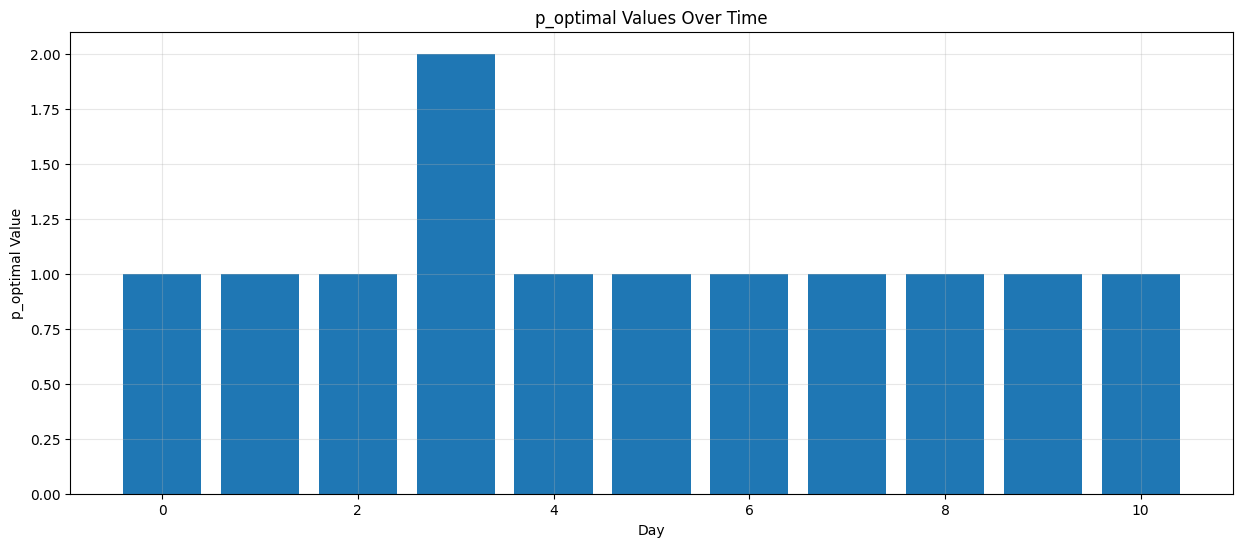

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract p_optimal from your results dictionary
p_optimal = results['p_optimal']
days = np.arange(len(p_optimal))

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(days, p_optimal)
plt.xlabel('Day')
plt.ylabel('p_optimal Value')
plt.title('p_optimal Values Over Time')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
from DML_tools import calculate_pnl
forecasted_returns = pd.DataFrame(np.concatenate(results['Y_hat_next_store']),
                                  index=returns_df_cleaned_prep.index[-L+252*4+1:])#,
                                #   columns=returns_df_cleaned_prep.columns)
actual_df = calculate_weighted_cluster_portfolio_returns(returns_df_cleaned_prep, 252*4, 20, .05)
actual_returns = actual_df.iloc[-L+252*4+1:]
print(actual_returns.equals(forecasted_returns))
print(actual_returns.head())
print(forecasted_returns.head())
print(forecasted_returns.shape)
print(actual_returns.shape)

pnl_series_n, _ = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="naive")
pnl_series_w, _ = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="weighted")
pnl_series_t, _ = calculate_pnl(forecasted_returns, actual_returns, contrarian = False, pnl_strategy="top")
print(pnl_series_n.head())

'''
Example
forecasted_returns = [[3,4],
                      [2,1],
                      [5,6]]
Each column is an asset, and each row is a day (prediction for next three days, for 2 assets)

actual_returns     = [[4,4],
                      [5,1],
                      [5,7]]

calculate_pnl returns a a series of PnL values for each day based on the strategy specified;

shape = [[1.04],
         [0.978],
         [1.01]]
    where each value is the PnL for that day based on the strategy (these are cumulative PnL)

'''

False
                      0         1         2         3    4             5   \
date                                                                        
2021-12-16 -4.238070e-07 -0.002220  0.001133 -0.000070  0.0 -3.171932e-07   
2021-12-17  3.670291e-06 -0.000183  0.001212 -0.000665  0.0  1.245246e-05   
2021-12-20  2.826891e-06  0.001626 -0.001525 -0.001912  0.0 -1.891895e-08   
2021-12-21  1.720923e-06  0.002530 -0.002977  0.001530  0.0  8.840764e-08   
2021-12-22  1.439160e-06  0.006395  0.004083  0.000570  0.0  8.574796e-06   

                      6         7         8         9         10        11  \
date                                                                         
2021-12-16  4.880066e-03 -0.000242  0.002624 -0.022068 -0.002549 -0.031726   
2021-12-17 -1.849606e-08  0.001556 -0.010885  0.009453 -0.000643  0.014038   
2021-12-20  3.926768e-03 -0.000277 -0.002136  0.001341 -0.000687  0.000984   
2021-12-21  2.840635e-03  0.000850  0.007421  0.014234  0.002939

'\nExample\nforecasted_returns = [[3,4],\n                      [2,1],\n                      [5,6]]\nEach column is an asset, and each row is a day (prediction for next three days, for 2 assets)\n\nactual_returns     = [[4,4],\n                      [5,1],\n                      [5,7]]\n\ncalculate_pnl returns a a series of PnL values for each day based on the strategy specified;\n\nshape = [[1.04],\n         [0.978],\n         [1.01]]\n    where each value is the PnL for that day based on the strategy (these are cumulative PnL)\n\n'

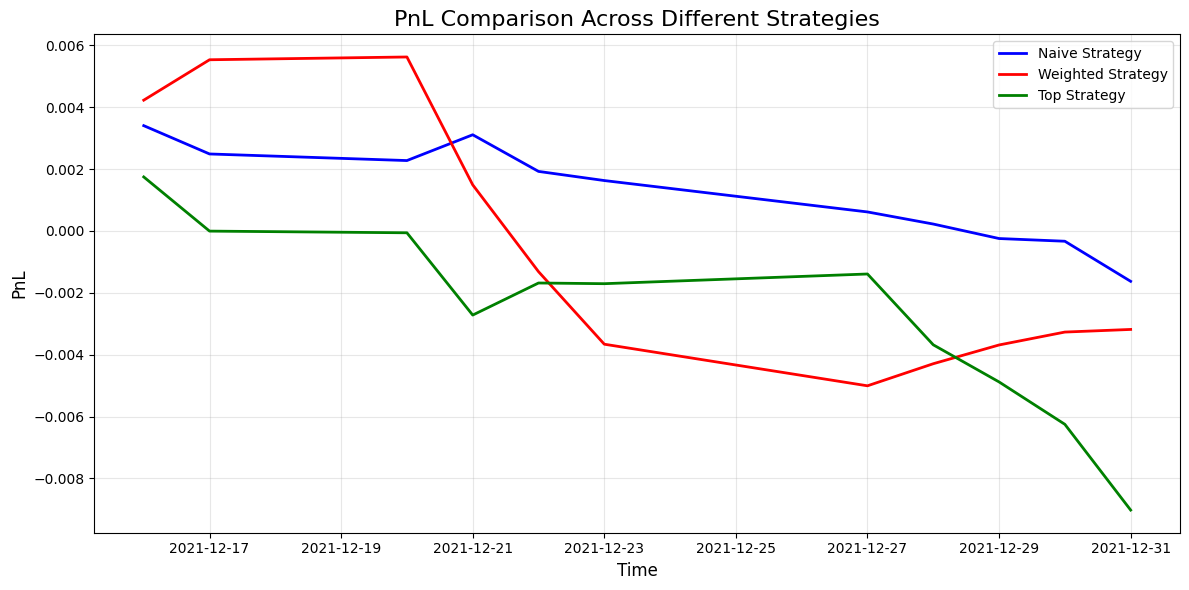

In [ ]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(pnl_series_n, color='blue', label='Naive Strategy', linewidth=2)
plt.plot(pnl_series_w, color='red', label='Weighted Strategy', linewidth=2)
plt.plot(pnl_series_t, color='green', label='Top Strategy', linewidth=2)

# Customize the plot
plt.title('PnL Comparison Across Different Strategies', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('pnl_comparison.png')
plt.show()

In [17]:
import numpy as np

# One-liner function
def get_metrics(series):
    daily_rets = series.diff().dropna()
    ann_ret = series.iloc[-1] * (252 / len(series))
    sharpe = (daily_rets.mean() * 252) / (daily_rets.std() * np.sqrt(252))
    return ann_ret*100, sharpe

# Get metrics for all strategies
for name, series in [("Naive", pnl_series_n), ("Weighted", pnl_series_w), ("Top", pnl_series_t)]:
    ann_ret, sharpe = get_metrics(series)
    print(f"{name}: {ann_ret:.4f}% annualized, Sharpe: {sharpe:.4f}")

Naive: -3.7295% annualized, Sharpe: -12.5867
Weighted: -7.2941% annualized, Sharpe: -6.4936
Top: -20.6773% annualized, Sharpe: -12.8363
